## Importing Libraries

In [30]:
import pandas as pd
import tensorflow as tf
import numpy as np
import dash
from tensorflow import keras
from keras.layers import TextVectorization
from keras.metrics import Precision, Recall, CategoricalAccuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, auc
from matplotlib import pyplot as plt


## Reading DataSet

In [2]:
df = pd.read_csv('train.csv')


In [3]:
df.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## Extracting Comments

In [4]:
X = df['comment_text']
y = df[df.columns[2:]].values


In [49]:
X.head()


0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

# Preprosessing Data

In [5]:
MAX_FEATURES = 200000


In [6]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')


### The max sequenece length of the Data is 1800

In [7]:
vectorizer.adapt(X.values)
vectorized_text = vectorizer(X.values)


In [8]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)


In [9]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))


In [10]:
model = Sequential()
model.add(Embedding(input_dim=MAX_FEATURES+1, output_dim=32))
model.add(Bidirectional(LSTM(units=32, activation='tanh')))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=6, activation='sigmoid'))


In [11]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')


In [12]:
model.build(input_shape=(None,1800))
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1800, 32)       │     6,400,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,491,686 (24.76 MB)

 Trainable params: 6,491,686 (24.76 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(train, epochs=10, validation_data=val)


Epoch 1/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 2456s 351ms/step - loss: 0.0826 - val_loss: 0.0482
Epoch 2/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1991s 285ms/step - loss: 0.0465 - val_loss: 0.0400
Epoch 3/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1986s 285ms/step - loss: 0.0405 - val_loss: 0.0376
Epoch 4/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1983s 284ms/step - loss: 0.0365 - val_loss: 0.0319
Epoch 5/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1977s 283ms/step - loss: 0.0323 - val_loss: 0.0286
Epoch 6/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1994s 286ms/step - loss: 0.0287 - val_loss: 0.0252
Epoch 7/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1991s 285ms/step - loss: 0.0262 - val_loss: 0.0224
Epoch 8/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1996s 286ms/step - loss: 0.0228 - val_loss: 0.0197
Epoch 9/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1992s 285ms/step - loss: 0.0203 - val_loss: 0.0172
Epoch 10/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1996s 286ms/step - loss: 0.0185 - val_loss: 0.0171


<Figure size 800x500 with 0 Axes>

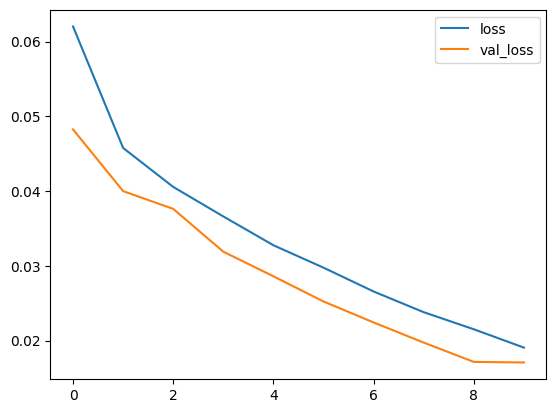

In [14]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()


In [15]:
# Calculate evaluation metrics for the entire test set without retraining
y_true_all, y_pred_all = [], []
for batch_X, batch_y in test.as_numpy_iterator():
    y_true_all.extend(batch_y)
    y_pred_all.extend(model.predict(batch_X))

y_true_all = np.array(y_true_all)
y_pred_all = (np.array(y_pred_all) > 0.5).astype(int)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_true_all, y_pred_all)
f1 = f1_score(y_true_all, y_pred_all, average='micro')
precision = precision_score(y_true_all, y_pred_all, average='micro')
recall = recall_score(y_true_all, y_pred_all, average='micro')
roc_auc = roc_auc_score(y_true_all, y_pred_all, average='micro')

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("ROC AUC Score:", roc_auc)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━

In [35]:
print("Accuracy:", accuracy)


Accuracy: 0.9698470411233701


Confusion Matrix:
91876	289	
324	3223	


<Figure size 1000x800 with 0 Axes>

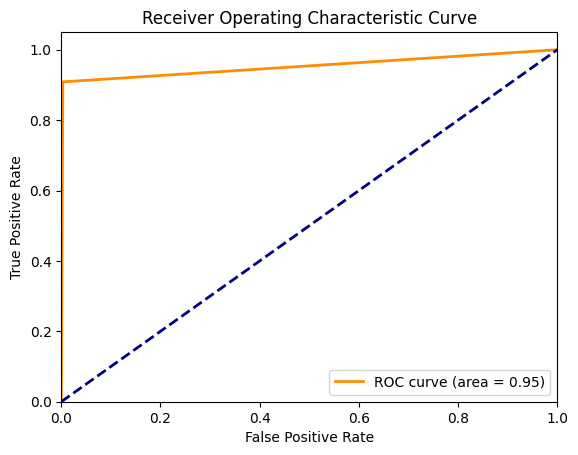

In [20]:
import seaborn as sns
# confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_all.ravel(), y_pred_all.ravel())
print("Confusion Matrix:")
for i in range(len(cm)):
    for j in range(len(cm[i])):
        print(cm[i][j], end='\t')
    print()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_true_all.ravel(), y_pred_all.ravel())
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()


## Testing and evaluation

In [21]:
input_text = vectorizer(['You freaking suck! I am going to hit you.'])
res = model.predict(input_text)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


In [22]:
batch_X, batch_y = test.as_numpy_iterator().next()

(model.predict(batch_X) > 0.5).astype(int)

res.shape


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


(1, 6)

Reference = [Reshaping the dataset](https://stackoverflow.com/questions/43604657/numpy-reshape-a-dataset)

In [23]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy


In [24]:
p = Precision()
r = Recall()
a = CategoricalAccuracy()


In [25]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    p.update_state(y_true, yhat)
    r.update_state(y_true, yhat)
    a.update_state(y_true, yhat)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━

In [26]:
print(f'Precision: {p.result().numpy()}, Recall:{r.result().numpy()}, Accuracy:{a.result().numpy()}')


Precision: 0.9217988848686218, Recall:0.9069898724555969, Accuracy:0.5386158227920532


## Predictions

In [39]:
import dash_bootstrap_components as dbc
from dash import html
from dash.dependencies import Output, Input, State


app = dash.Dash(__name__, external_stylesheets=[dbc.themes.SUPERHERO])

# Define layout using Bootstrap components
app.layout = dbc.Container([
    html.H1("Toxicity Comment Identifier", className="display-4 text-center my-4"),
    dbc.Input(id='comment-input', type='text', placeholder='Enter your comment...',
              className="form-control-lg mb-3"),
    dbc.Button('Score', id='score-button', color='primary', className="btn-lg mb-3"),
    html.Div(id='result', className="lead text-center")
], className="my-5")

def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)

    predictions = {}
    for idx, col in enumerate(df.columns[2:]):
        predictions[col] = {'prediction': results[0][idx] > 0.5, 'score': results[0][idx]}

    return predictions


# Define callback to update result
@app.callback(
    Output('result', 'children'),
    [Input('score-button', 'n_clicks')],
    [dash.dependencies.State('comment-input', 'value')]
)
def update_result(n_clicks, comment):
    if n_clicks:
        predictions = score_comment(comment)  # Using your existing function
        
        result_divs = []
        for label, pred in predictions.items():
            result_divs.append(
                html.Div([
                    html.Span(f"{label}: {'True' if pred['prediction'] else 'False'}"),
                    html.Span(f" (Score: {pred['score']:.4f})", style={'margin-left': '10px'})
                ])
            )
        
        return result_divs

if __name__ == '__main__':
    app.run_server(debug=True)
